# Importation des bibliothèques

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras

# Préparation de la dataset

## Téléchargement à partir de github

In [ ]:
! git clone https://github.com/MetaneYoussef/Face-Mask-Dataset

Cloning into 'Face-Mask-Dataset'...
remote: Enumerating objects: 60519, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 60519 (delta 0), reused 0 (delta 0), pack-reused 60518
Receiving objects: 100% (60519/60519), 1.01 GiB | 30.56 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (60567/60567), done.


## Importation de la dataset

In [ ]:
import pathlib
data_dir  = pathlib.Path("/content/Face-Mask-Dataset/dataset2")

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

### Dataset de l'entrainement 80% (32418 images)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed= 40,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40523 files belonging to 3 classes.
Using 32419 files for training.


### Dataset du validation 16% (6484 images)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=40,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40523 files belonging to 3 classes.
Using 8104 files for validation.


### Dataset de test 4% (1621 images)

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 204
Number of test batches: 50


## Aperçu de notre Dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Incorrect_Mask', 'No_mask', 'With_Mask']


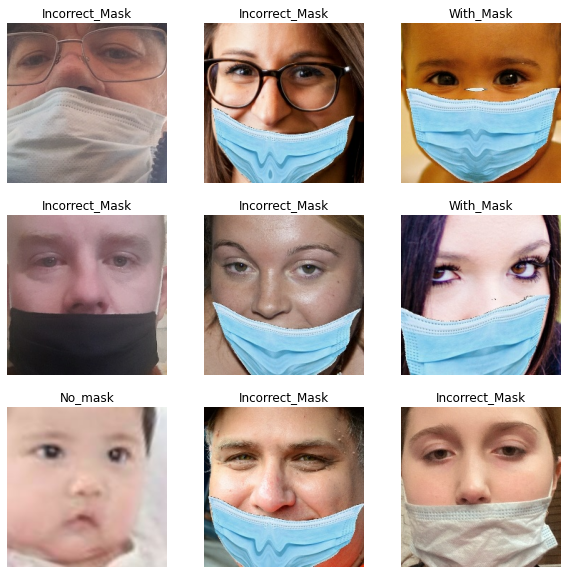

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Construction du modèle (Transfer learning avec ImageNet-V2)

## Augmentation des données

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.4),
])

## Normalization des données

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## importation du modèle

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


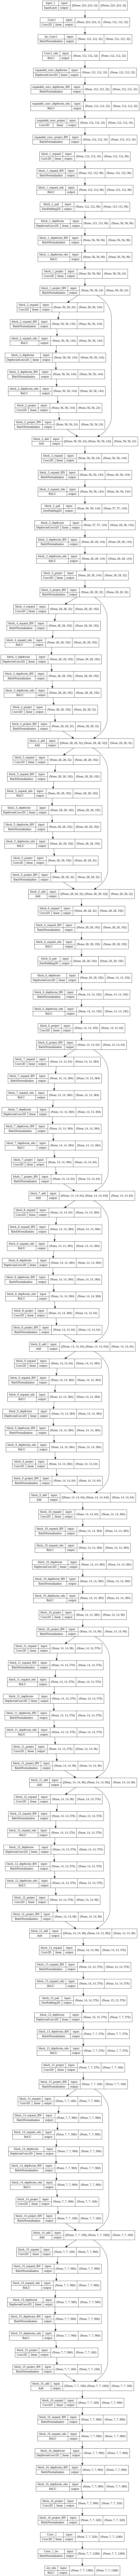

In [ ]:
tf.keras.utils.plot_model(base_model,show_shapes=True,show_layer_activations=True)

## Mise au point du modéle 

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# Modèle

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3)(x)
modeloo = tf.keras.Model(inputs, outputs)

In [ ]:
modeloo.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(modeloo)

# Entrainement

In [ ]:
loss, accuracy = modeloo.evaluate(test_ds)
print('Test accuracy :', accuracy)

50/50 [==============================] - 14s 47ms/step - loss: 1.2657 - accuracy: 0.3719
Test accuracy : 0.37187498807907104


In [ ]:
history_fine = modeloo.fit(train_ds,
                         epochs=10,
                         validation_data = val_ds,
                         )

Epoch 1/10
1014/1014 [==============================] - 87s 81ms/step - loss: 0.0945 - accuracy: 0.9661 - val_loss: 0.0336 - val_accuracy: 0.9869
Epoch 2/10
1014/1014 [==============================] - 81s 80ms/step - loss: 0.0486 - accuracy: 0.9834 - val_loss: 0.0386 - val_accuracy: 0.9855
Epoch 3/10
1014/1014 [==============================] - 81s 80ms/step - loss: 0.0422 - accuracy: 0.9852 - val_loss: 0.0351 - val_accuracy: 0.9883
Epoch 4/10
1014/1014 [==============================] - 82s 81ms/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0288 - val_accuracy: 0.9888
Epoch 5/10
1014/1014 [==============================] - 82s 81ms/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 6/10
1014/1014 [==============================] - 81s 80ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0376 - val_accuracy: 0.9875
Epoch 7/10
1014/1014 [==============================] - 81s 80ms/step - loss: 0.0294 - accuracy: 0.9894 - val_loss: 0.0280 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = modeloo.evaluate(test_ds)
print('Test accuracy :', accuracy)

# Sauvegarder le modèle

In [ ]:
modeloo.save('model_CNN.h5')